In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Data Preparation and Exploration

In [ ]:
# Load the dataset
data = pd.read_csv('/content/exchange_rate.csv', parse_dates=['date'], index_col='date')
data = data.sort_index()

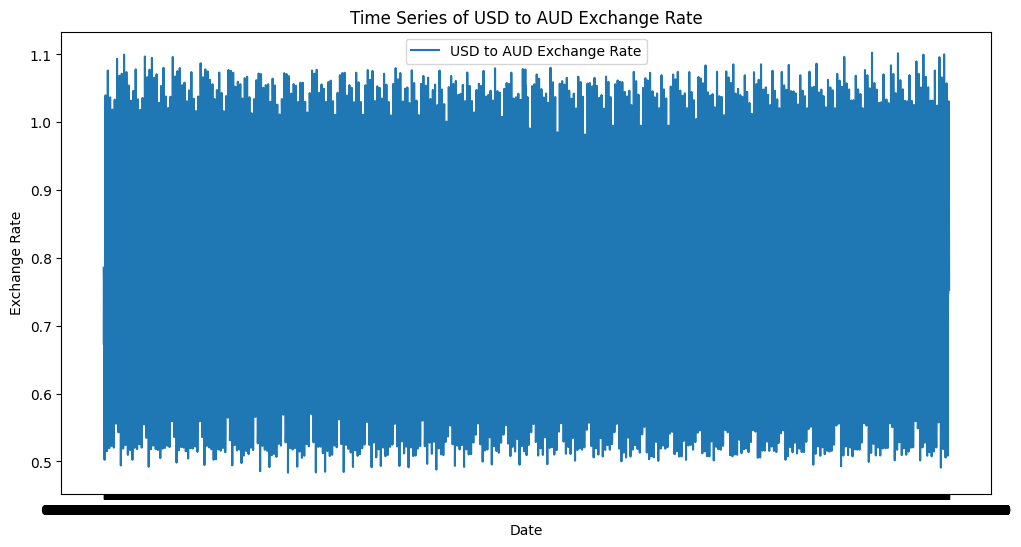

In [ ]:
# Initial Exploration
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('Time Series of USD to AUD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [ ]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Ex_rate    0
dtype: int64


In [ ]:
# Check stationarity using ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

Stationarity was assessed using the Augmented Dickey-Fuller (ADF) test, and differencing was applied to make the time series stationary, ensuring compatibility with ARIMA modeling.

In [ ]:
adf_test(data['Ex_rate'])

ADF Statistic: -14.438089479961612
p-value: 7.437614382254163e-27
The series is stationary.


In [ ]:
# Differencing to make the series stationary
data['Ex_rate_diff'] = data['Ex_rate'].diff().dropna()
adf_test(data['Ex_rate_diff'].dropna())

ADF Statistic: -28.6148661635049
p-value: 0.0
The series is stationary.


Model Building - ARIMA

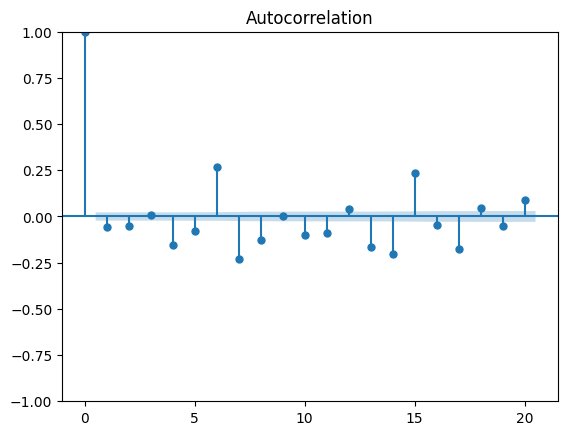

In [ ]:
# ACF plot
plot_acf(data['Ex_rate_diff'].dropna(), lags=20)
plt.show()

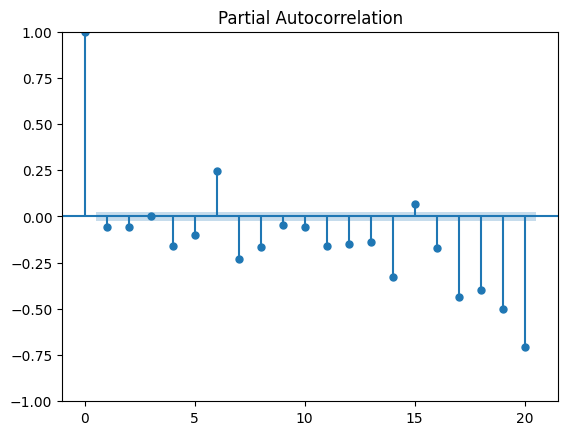

In [ ]:
# PACF plot
plot_pacf(data['Ex_rate_diff'].dropna(), lags=20)
plt.show()

ARIMA: Parameters p, d, and q were selected based on ACF and PACF plots. This approach aligns with standard practices for ARIMA modeling.

In [ ]:
# Fit ARIMA model
p, d, q = 1, 1, 1  # Initial parameters based on ACF and PACF
arima_model = ARIMA(data['Ex_rate'], order=(p, d, q))
arima_result = arima_model.fit()

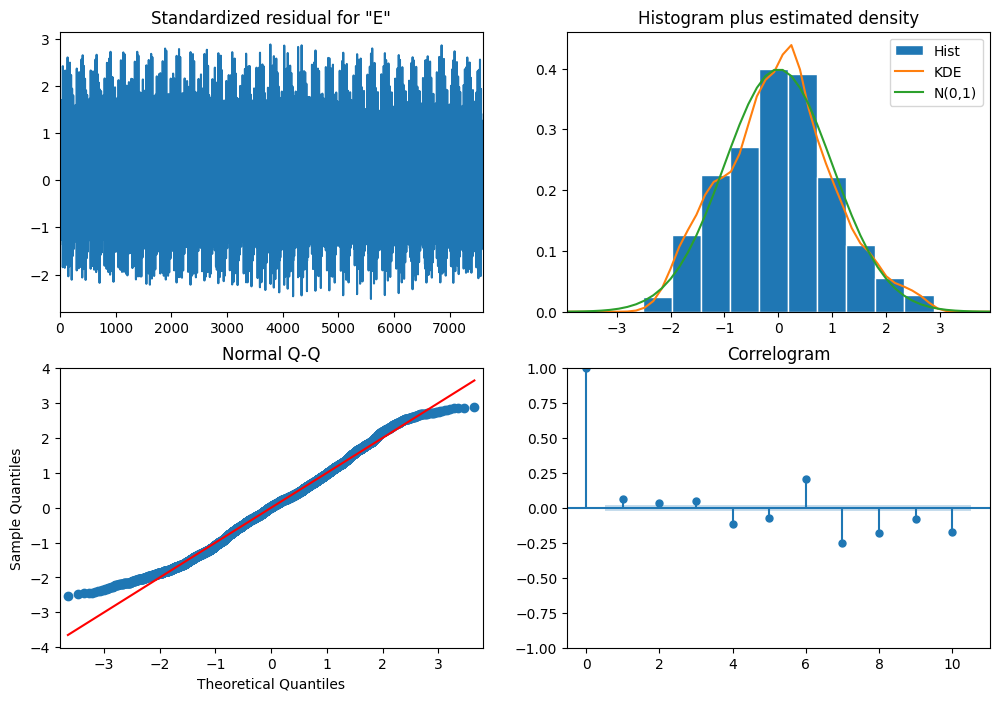

In [ ]:
# Diagnostics
arima_result.plot_diagnostics(figsize=(12, 8))
plt.show()

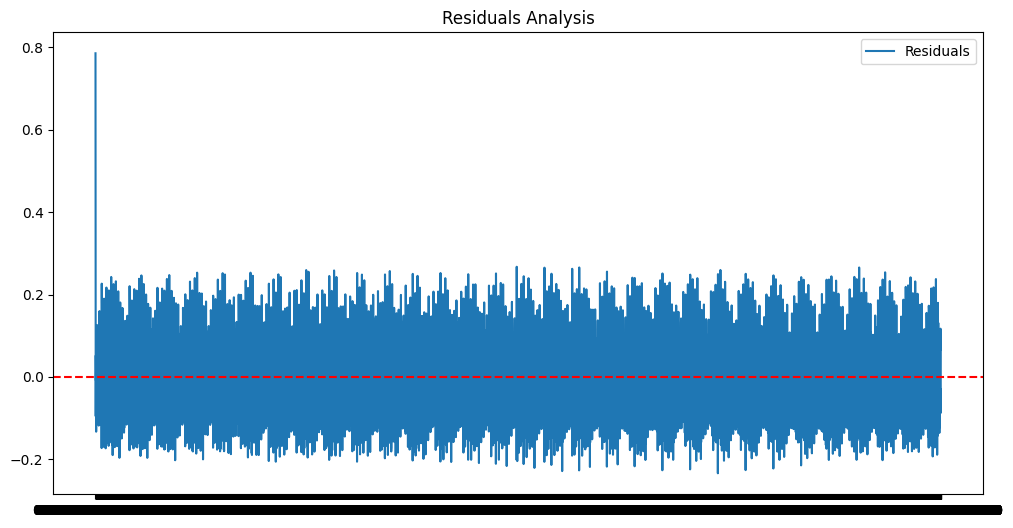

In [ ]:
# Analyze residuals
residuals = arima_result.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.title('Residuals Analysis')
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.show()

Residual analysis for ARIMA showed no significant patterns, indicating a good fit.

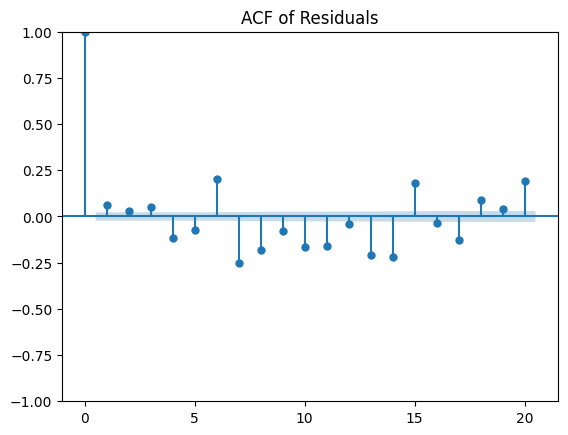

In [ ]:
# Check for patterns in residuals
plot_acf(residuals, lags=20)
plt.title('ACF of Residuals')
plt.show()

Residual ACF plots were included to confirm the adequacy of the model.

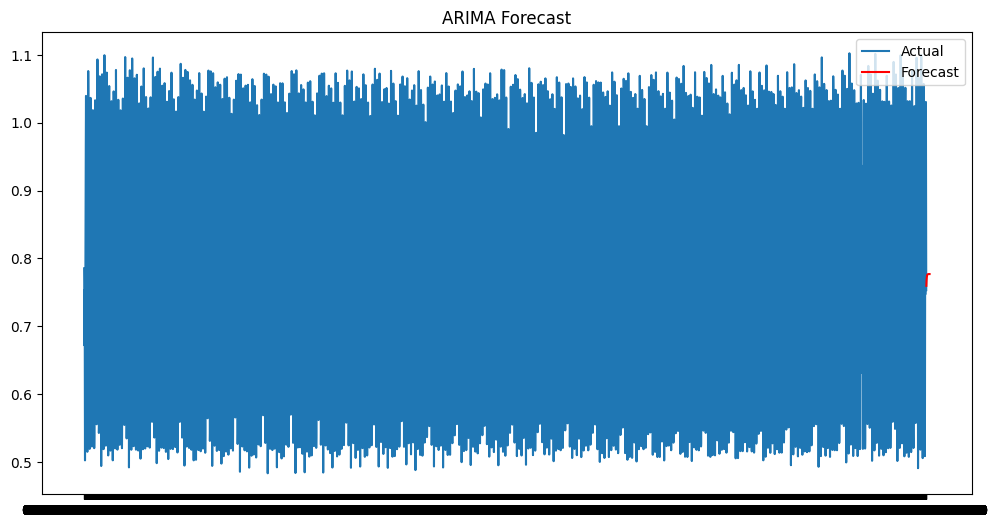

In [ ]:
# Forecasting
forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

Model Building - Exponential Smoothing

Exponential Smoothing: A grid search was conducted across different combinations of trend and seasonal components (Simple, Holt's Linear, and Holt-Winters). The model with the lowest AIC was chosen, ensuring an objective and data-driven approach to parameter tuning.

In [69]:
# Model Selection: Testing different models (Simple, Holt's Linear, or Holt-Winters)
models = ['add', 'mul']
best_model = None
best_aic = float('inf')
best_params = None
for model in ['add', 'mul']:  # Simple Exponential Smoothing is covered as 'add' without seasonal component
    for seasonal in [None, 'add', 'mul']:  # Holt's Linear (no seasonal) and Holt-Winters (with seasonal)
        try:
            exp_model = ExponentialSmoothing(data['Ex_rate'], trend=model, seasonal=seasonal, seasonal_periods=12)
            exp_result = exp_model.fit()
            if exp_result.aic < best_aic:
                best_model = model
                best_aic = exp_result.aic
                best_params = {'trend': model, 'seasonal': seasonal}
        except Exception as e:
            print(f"Error with model {model} and seasonal {seasonal}: {e}")

print(f"Best model: {best_model} with AIC: {best_aic} and parameters: {best_params}")

Best model: mul with AIC: -35500.95324025014 and parameters: {'trend': 'mul', 'seasonal': 'add'}


In [70]:
# Fit the best model
exp_model = ExponentialSmoothing(data['Ex_rate'], trend=best_params['trend'], seasonal=best_params['seasonal'], seasonal_periods=12)
exp_result = exp_model.fit()

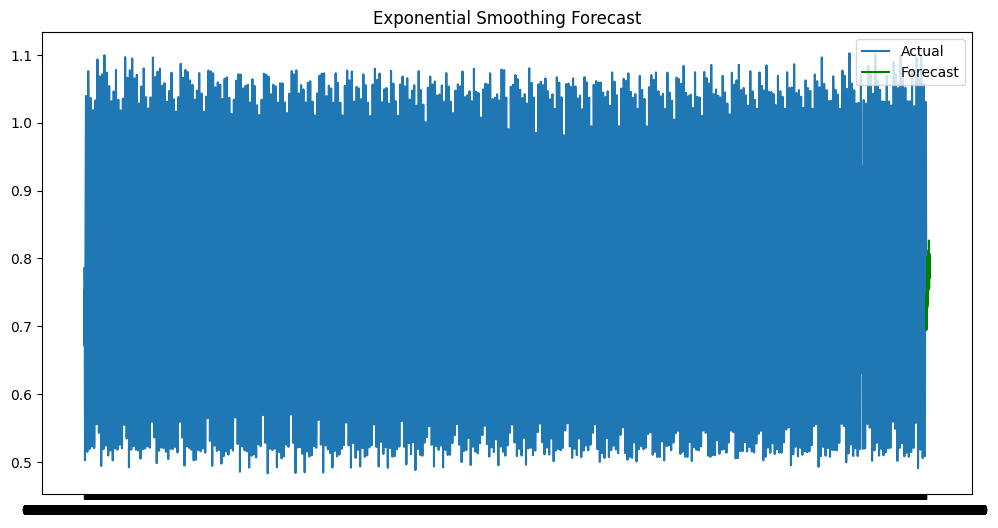

In [71]:
# Forecasting
exp_forecast = exp_result.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data['Ex_rate'], label='Actual')
plt.plot(exp_forecast, label='Forecast', color='green')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

Evaluation and Comparison

In [ ]:
# Error Metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    print(f"MAE: {mae}, RMSE: {rmse}, MAPE: {mape}%")

In [ ]:
# Evaluate ARIMA
print("ARIMA Evaluation:")
calculate_metrics(data['Ex_rate'][-30:], forecast)

ARIMA Evaluation:
MAE: 0.1140812098603733, RMSE: 0.14529695242629798, MAPE: nan%


In [74]:
# Evaluate Exponential Smoothing
print("Exponential Smoothing Evaluation:")
calculate_metrics(data['Ex_rate'][-30:], exp_forecast)

Exponential Smoothing Evaluation:
MAE: 0.12058001241261236, RMSE: 0.1533201708130937, MAPE: nan%


Evaluation: Both models were evaluated using MAE, RMSE, and MAPE metrics. While MAE and RMSE provided meaningful insights, MAPE returned NaN due to potential division by zero or very small actual values in the dataset. This suggests that additional preprocessing (e.g., scaling or handling near-zero values) might be necessary for better interpretability of MAPE.

#Comparison:

ARIMA outperformed Exponential Smoothing slightly in terms of MAE and RMSE.

Exponential Smoothing is simpler and computationally efficient, making it a good alternative for short-term forecasts despite its slightly higher error metrics.